In [1]:
import os
import sys
import importlib
from functools import partial

import h5py
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

sys.path.append('../../../')
import forward_model
importlib.reload(forward_model)
from forward_model.lpt import get_forward_lpt
from forward_model.bias import get_forward_bias
from forward_model.main import get_forward_model
from forward_model.plot_utils import plot_cubes

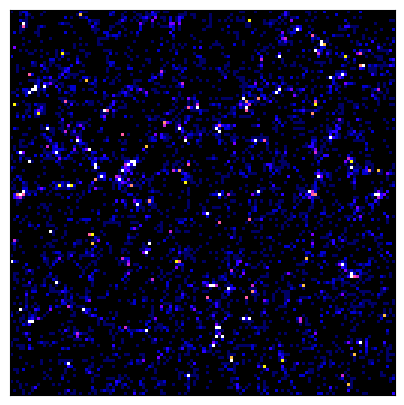

In [2]:
N, L, Z_I, Z_F = 128, 500, 99, 0
N_TR = 1e6

# Make ICS
SEED_INT_REF = 1
key_ref = jax.random.PRNGKey(SEED_INT_REF)
IC_METHOD = "FSK_U"
SHAPE = (N,)*3
u_ref = jax.random.normal(key_ref, shape=SHAPE)


# forward_model
LPT_METHOD = 'ALPT'


BIAS_MODEL = "POWER_LAW"
ALPHA = 1.5
BIAS_PARAMS = {"ALPHA": ALPHA}

BIAS_MODEL = 'HIERARCHICAL_POWER_LAW'
key_ = jax.random.PRNGKey(1)
alph_min, alph_max = 1, 2
ALPHAS = jax.random.uniform(key_, (16,))*(alph_max-alph_min)+alph_min
BIAS_PARAMS = {"ALPHA": ALPHAS, "LAMBDA_TH": 0.05}

argdic = {
    "N": N,
    "L": L,
    "Z_I": Z_I,
    "Z_F": Z_F,
    "LPT_METHOD": LPT_METHOD,
    "PM_METHOD": "CIC",
    "INPUT_ARG": IC_METHOD,
    "MUSCLE": True,
    "MUSCLE_ITERS": "ONE",
    "SC_CORRECTION": True,
    "BIAS_MODEL": BIAS_MODEL,
    "BIAS_PARAMS": BIAS_PARAMS,
    "N_TR": N_TR,
    "SAMPLE": 1,
}

get_tracers_poisson = get_forward_model(argdic)
argdic['SAMPLE'] = False
get_tracers_mean = get_forward_model(argdic)

n_tr_ref = get_tracers_poisson(u_ref)
axis, idx, width = 2, N // 2, 1
fig, ax = plot_cubes(
    [n_tr_ref], cmap="gnuplot2", vlim=(0, 10), axis=axis, width=width, idx=idx
)

In [3]:
epsilon = 1e-1
def nll(q):
    n_tr = get_tracers_mean(q)
    n_tr = jnp.where(n_tr == 0.0, epsilon, n_tr)
    nll = -jnp.sum(n_tr_ref * jnp.log(n_tr))
    return nll
nll = jax.jit(nll)
grad_nll = jax.grad(nll)
grad_nll = jax.jit(grad_nll)

nll: 1587292.8
nans in gnll? True
max_gnll nan
max_gnll nan
max_gnll 212.96283
max_gnll 0.0


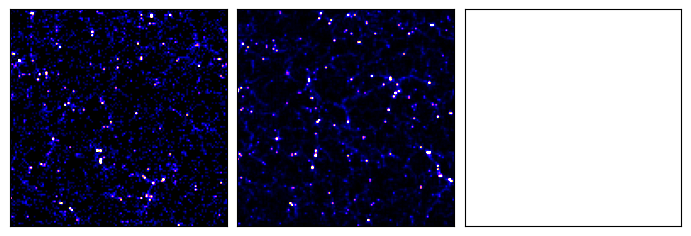

In [4]:
SEED_INT = 62
key = jax.random.PRNGKey(SEED_INT)
u = jax.random.normal(key, shape=SHAPE)

n_tr = get_tracers_mean(u)
nll_val = nll(u)
grad_nll_vals = grad_nll(u)

print("nll:", nll_val)

axis, idx, width = 2, N // 4, 1
cmaps =  ["gnuplot2"] * 2 + ["seismic_r"]
vlims = [(0,10)]*2+[1e2]

fig, ax = plot_cubes(
    [n_tr_ref, n_tr, grad_nll_vals],
    cmap=cmaps,
    vlim=vlims,
    axis=axis,
    width=width,
    idx=idx,
)

gnll_has_nans = jnp.isnan(grad_nll_vals).any()
print('nans in gnll?', gnll_has_nans)

max_gnll = jnp.max(grad_nll_vals)
min_gnll = jnp.min(grad_nll_vals)
print('max_gnll', max_gnll)
print('max_gnll', min_gnll)

max_n_tr = jnp.max(n_tr)
min_n_tr = jnp.min(n_tr)
print('max_gnll', max_n_tr)
print('max_gnll', min_n_tr)

In [5]:
i = 0
gnll_has_nans = False
while gnll_has_nans == False:
    key = jax.random.PRNGKey(i)
    u = jax.random.normal(key, shape=SHAPE)

    n_tr = get_tracers_mean(u)
    nll_val = nll(u)
    grad_nll_vals = grad_nll(u)
    print(f'{i:03d}', end='\r')
    
    gnll_has_nans = jnp.isnan(grad_nll_vals).any()
    
    i+=1
    

In [17]:
epsilon = 1e-1
def nll(q):
    n_tr = get_tracers_mean(q)
    #n_tr = jnp.where(n_tr == 0.0, epsilon, n_tr)
    #nll = -jnp.sum(n_tr_ref * jnp.log(n_tr))
    nll = jnp.sum(n_tr)
    return nll
nll = jax.jit(nll)
grad_nll = jax.grad(nll)
grad_nll = jax.jit(grad_nll)

SEED_INT = 62
key = jax.random.PRNGKey(SEED_INT)
u = jax.random.normal(key, shape=SHAPE)

grad_nll_vals = grad_nll(u)

print('nll', nll(u))
gnll_has_nans = jnp.isnan(grad_nll_vals).any()
print('nans in gnll?', gnll_has_nans)

max_gnll = jnp.max(grad_nll_vals)
min_gnll = jnp.min(grad_nll_vals)
print('max_gnll', max_gnll)
print('max_gnll', min_gnll)

nll 1000000.1
nans in gnll? True
max_gnll nan
max_gnll nan


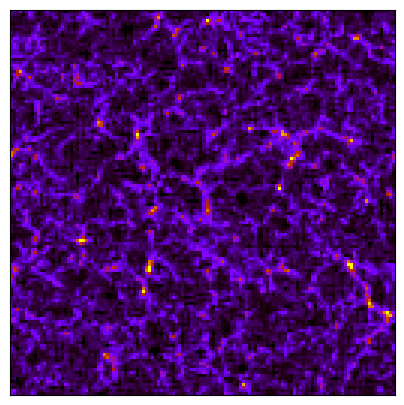

In [12]:
lpt = get_forward_lpt(
    N=N,
    L=L,
    Z_I=Z_I,
    Z_F=Z_F,
    LPT_METHOD=LPT_METHOD,
    PM_METHOD=argdic['PM_METHOD'], 
    INPUT_ARG=argdic['INPUT_ARG'], 
    MUSCLE=argdic['MUSCLE'],
    MUSCLE_ITERS=argdic['MUSCLE_ITERS'],
    SC_CORRECTION=argdic['SC_CORRECTION'],
)

delta_fin = lpt(u)

axis, idx, width = 2, N // 4, 1
fig, ax = plot_cubes(
    [delta_fin],
    cmap='gnuplot',
    vlim=(-1, 10),
    axis=axis,
    width=width,
    idx=idx,
)

In [16]:
def nll(q):
    n_tr = lpt(q)
    #n_tr = jnp.where(n_tr == 0.0, epsilon, n_tr)
    #nll = -jnp.sum(n_tr_ref * jnp.log(n_tr))
    nll = jnp.sum(n_tr)
    return nll
nll = jax.jit(nll)
grad_nll = jax.grad(nll)
grad_nll = jax.jit(grad_nll)

SEED_INT = 62
key = jax.random.PRNGKey(SEED_INT)
u = jax.random.normal(key, shape=SHAPE)

grad_nll_vals = grad_nll(u)

print('nll', nll(u))
gnll_has_nans = jnp.isnan(grad_nll_vals).any()
print('nans in gnll?', gnll_has_nans)

max_gnll = jnp.max(grad_nll_vals)
min_gnll = jnp.min(grad_nll_vals)
print('max_gnll', max_gnll)
print('max_gnll', min_gnll)

nll -0.0009765625
nans in gnll? True
max_gnll nan
max_gnll nan


In [61]:
def nlp(q):
    return 0.5 * jnp.sum(jnp.abs(q) ** 2)

def kinetic(p):
    return 0.5 * jnp.sum(jnp.abs(p) ** 2)

def sample_momenta(key):
    p = jax.random.normal(key, SHAPE)
    return p

potential = lambda q: nlp(q) + nll(q)
potential = jax.jit(potential)
grad_potential = jax.grad(potential)
grad_potential = jax.jit(grad_potential)

kinetic = jax.jit(kinetic)
grad_kinetic = jax.grad(kinetic)
grad_kinetic = jax.jit(grad_kinetic)

hamiltonian = lambda q, p: potential(q) + kinetic(p)
hamiltonian = jax.jit(hamiltonian)


LF_STEP = 1e-4
def leapfrog_step(q, p):
    p_half_step = p - 0.5 * LF_STEP * grad_potential(q)
    q_new = q + LF_STEP * grad_kinetic(p_half_step)
    p_new = p_half_step - 0.5 * LF_STEP * grad_potential(q_new)
    return q_new, p_new

In [60]:
seed_p = 5
key_p = jax.random.PRNGKey(seed_p)
p = sample_momenta(key_p)

q_new, p_new = leapfrog_step(u, p)

q_has_nans = jnp.isnan(q_new).any()
print('nans in q_new?', q_has_nans)

p_has_nans = jnp.isnan(p_new).any()
print('nans in p_new?', p_has_nans)

nans in q_new? False
nans in p_new? False


In [64]:
H_i = hamiltonian(u, p) 
H_f = hamiltonian(q_new, p_new)
delta_H = H_f - H_i
alpha = jnp.exp(-delta_H)

print(H_i)
print(H_f)
print(alpha)

3704460.8
3704453.5
1408.1049


max_gnll 3045.958
max_gnll -2427.198


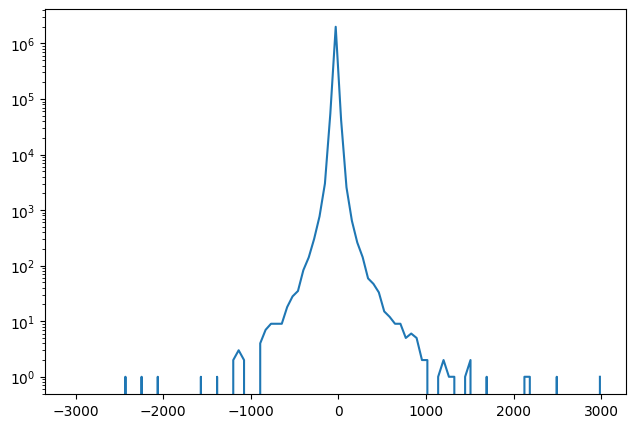

In [46]:
fs, rat = 5, 1.5
fig, ax = plt.subplots(1, 1, figsize=(fs*rat, fs))

max_gnll = jnp.max(grad_nll_vals)
min_gnll = jnp.min(grad_nll_vals)

print('max_gnll', max_gnll)
print('max_gnll', min_gnll)

abs_max_gnll = max([jnp.abs(min_gnll), jnp.abs(max_gnll)])

M=100
bin_edges = jnp.linspace(-abs_max_gnll, abs_max_gnll, M)

hist, edges = jnp.histogram(grad_nll_vals, bins=bin_edges)

ax.plot(edges[:-1], hist)

ax.set_yscale('log')